In [501]:
# from scipy.optimize import curve_fit
# import pandas as pd
# import random
import sys, copy
# from IPython.display import clear_output
from matplotlib import pyplot as plt
from math import sqrt
from pprint import pprint


sys.path.append('../..')

# from model import run
# from model import plot_utils as pu
# from model import processing
from model.amm.omnipool_amm import OmnipoolState, execute_swap, execute_add_liquidity, usd_price, cash_out_omnipool, execute_remove_liquidity, lrna_price
from model.amm.agents import Agent
from model.amm.trade_strategies import price_manipulation, omnipool_arbitrage, price_manipulation_multiple_blocks
from model.amm.global_state import GlobalState, value_assets
# import model.amm.omnipool_amm as oamm




In [502]:
oracle_mult_list = [1]
# lp_multiplier_list = [0.01, 0.02, 0.05, 0.08, 0.1]
max_lp_mult = 0.5
max_lp_mult = 0.04
lp_steps = 1
lp_multiplier_list = [max_lp_mult / lp_steps * n for n in range(1, lp_steps+1)]
# trade_mult_list = [0.001, 0.002, 0.005, 0.01, 0.02]
# max_trade_mult = 0.02
# trade_steps = 20
# trade_mult_list = [max_trade_mult / trade_steps * n for n in range(1, trade_steps+1)]
max_price_move = 0.01
price_steps = 500
price_move_list = [max_price_move / price_steps * n for n in range(1, price_steps+1)]

max_lp_price_move_up = 20
lp_price_steps_up = 1
lp_price_move_list = [max_lp_price_move_up / lp_price_steps_up * n for n in range(1, lp_price_steps_up+1)]
max_inv_lp_price_move_down = 50
lp_price_steps_down = 1
lp_price_move_list_inv = [lp_price_steps_down * n / max_inv_lp_price_move_down for n in range(1, lp_price_steps_down+1)]
lp_price_move_list.extend(lp_price_move_list_inv)
lp_price_move_list.sort()

In [503]:
tokens = {
    'HDX': {'liquidity': 44000000, 'LRNA': 275143},
    'WETH': {'liquidity': 1400, 'LRNA': 2276599},
    # 'WETH': {'liquidity': 1400, 'LRNA': 546461},
    'DAI': {'liquidity': 2268262, 'LRNA': 2268262},
    'DOT': {'liquidity': 88000, 'LRNA': 546461},
    # 'DOT': {'liquidity': 88000, 'LRNA': 2276599},
    'WBTC': {'liquidity': 47, 'LRNA': 1145210},
}

prices = {tkn: tokens[tkn]['LRNA']/tokens[tkn]['liquidity'] for tkn in tokens}

# Profitability of add liquidity attack where asset is sold to the pool at manipulated price

In [504]:

profits = []
# price_moves = []
for i in range(len(oracle_mult_list)):
    oracle_mult = oracle_mult_list[i]
    profits.append([])
    # price_moves.append([])
    for j in range(len(lp_multiplier_list)):
        lp_multiplier = lp_multiplier_list[j]
        profits[i].append([])
        # price_moves[i].append([])
        for k in range(len(price_move_list)):
            price_move = price_move_list[k]

            trade_mult = 1/sqrt(1 - price_move) - 1

            trade_size = tokens['WETH']['liquidity'] * trade_mult

            init_oracle = {
                'liquidity': {tkn: tokens[tkn]['liquidity'] for tkn in tokens},
                'volume_in': {tkn: 0 for tkn in tokens},
                'volume_out': {tkn: 0 for tkn in tokens},
                'price': {tkn: oracle_mult * prices[tkn] for tkn in tokens},
            }

            omnipool: OmnipoolState = OmnipoolState(
                tokens=tokens,
                preferred_stablecoin='DAI',
                oracles={'price': 19, 'volatility': 19},
                last_oracle_values={
                    'price': copy.deepcopy(init_oracle),
                    'volatility': copy.deepcopy(init_oracle),
                },
                asset_fee = 0.0025,
                lrna_fee = 0.0005,
                # max_withdrawal_per_block=0.05,
                # max_lp_per_block=0.05,
                # remove_liquidity_volatility_threshold=0.01,
            )

            market_prices = {tkn: usd_price(omnipool, tkn) for tkn in omnipool.asset_list}

            holdings = {tkn: 1000000000 for tkn in omnipool.asset_list}
            agent = Agent(holdings=holdings)

            swap_state, swap_agent = execute_swap(
                state=omnipool.copy(),
                agent=agent.copy(),
                tkn_sell='WETH',
                tkn_buy='DAI',
                # sell_quantity=trade_size
                buy_quantity=10929
            )

            # manipulated_price = swap_state.lrna['DOT'] / swap_state.liquidity['DOT']
            # init_spot_price = omnipool.lrna['DOT'] / omnipool.liquidity['DOT']
            # price_moves[i][j].append((init_spot_price - manipulated_price) / init_spot_price)

            add_state, add_agent = execute_add_liquidity(
                state=swap_state.copy(),
                agent=swap_agent.copy(),
                tkn_add='WETH',
                quantity=swap_state.liquidity['WETH'] * 37/1400
            )

            add_state2, add_agent2 = execute_add_liquidity(
                state=add_state.copy(),
                agent=add_agent.copy(),
                tkn_add='DAI',
                quantity=swap_state.liquidity['DAI'] * 113402/2268262
            )

            global_state = GlobalState(
                pools={'omnipool': add_state2},
                agents={'attacker': add_agent2},
                external_market=market_prices
            )

            arb_state = omnipool_arbitrage('omnipool', 20).execute(
                state=global_state.copy(),
                agent_id='attacker'
            )

            arbed_pool = arb_state.pools['omnipool']
            arbed_agent = arb_state.agents['attacker']

            # remove_state, remove_agent = execute_remove_liquidity(
            #     state=arbed_pool.copy(),
            #     agent=arbed_agent.copy(),
            #     tkn_remove='DOT',
            #     quantity=arbed_agent.holdings[('omnipool', 'DOT')]
            # )
            #
            # remove_state2, remove_agent2 = execute_remove_liquidity(
            #     state=remove_state.copy(),
            #     agent=remove_agent.copy(),
            #     tkn_remove='DAI',
            #     quantity=remove_agent.holdings[('omnipool', 'DAI')]
            # )

            initial_value = cash_out_omnipool(omnipool, agent, market_prices)
            # final_value = cash_out_omnipool(remove_state2, remove_agent2, market_prices)
            final_value = cash_out_omnipool(arbed_pool, arbed_agent, market_prices)
            # profit_dict[(oracle_mult, lp_multiplier, trade_mult)] = final_value - initial_value
            profits[i][j].append(final_value - initial_value)

        # price_moves[i][j] = max(price_moves[i][j])

print(profits)


[[[-83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83.22265625, -83

In [505]:
max_profit = profits[0][0][0]
max_index = (0, 0, 0)
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            if profits[i][j][k] > max_profit:
                max_profit = profits[i][j][k]
                max_index = (i, j, k)

print(max_profit)
print(profits[max_index[0]][max_index[1]][max_index[2]])

-83.22265625
-83.22265625


In [506]:
# oracle_dataset = [profits[i][max_index[1]][max_index[2]] for i in range(len(oracle_mult_list))]
# lp_dataset = [profits[max_index[0]][i][max_index[2]] for i in range(len(lp_multiplier_list))]
# price_dataset = [profits[max_index[0]][max_index[1]][i] for i in range(len(price_move_list))]
# print(oracle_dataset)
# print(lp_dataset)
# print(trade_dataset)

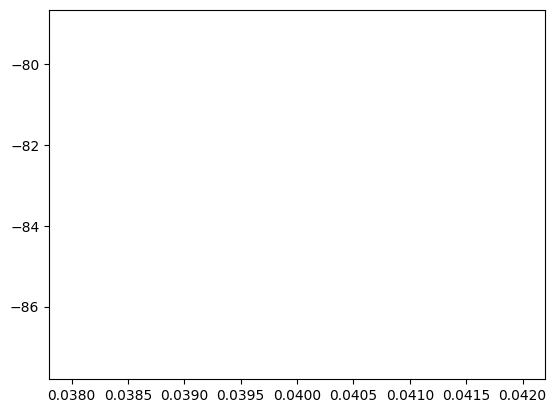

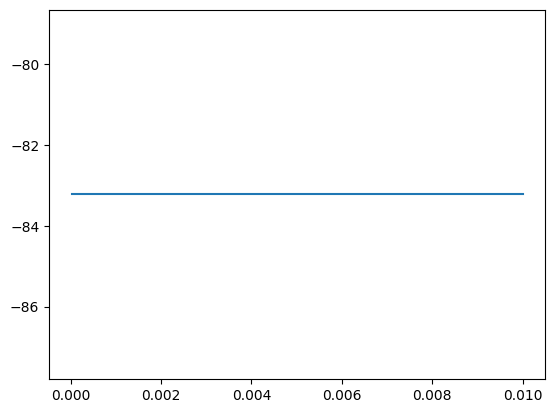

In [507]:
oracle_dataset = [profits[i][max_index[1]][max_index[2]] for i in range(len(oracle_mult_list))]
lp_dataset = [profits[max_index[0]][i][max_index[2]] for i in range(len(lp_multiplier_list))]
price_dataset = [profits[max_index[0]][max_index[1]][i] for i in range(len(price_move_list))]

# plt.plot(oracle_mult_list, oracle_dataset)
# plt.show()
plt.plot(lp_multiplier_list, lp_dataset)
plt.show()
plt.plot(price_move_list, price_dataset)
plt.show()

In [508]:

# Test monotonicity of lp multiplier
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with lp multiplier
for i in range(len(oracle_mult_list)):
    for j in range(len(price_move_list)):
        data = [profits[i][k][j] for k in range(len(lp_multiplier_list))]
        for k in range(len(data) - 1):
            if data[k] * dir_sign >= data[k+1] * dir_sign:
                non_monotonic[(i,j)] = data
                break
if len(non_monotonic) == 0:
    print('lp multiplier profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)


lp multiplier profits are monotonic


In [509]:

# Test monotonicity of price move
non_monotonic = {}
dir_sign = 1  # we expect profit to increase with price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        data = profits[i][j]
        # print(data)
        for k in range(len(data) - 1):
            if data[k] * dir_sign >= data[k+1] * dir_sign:
                non_monotonic[(i,j)] = copy.deepcopy(data)
                break

if len(non_monotonic) == 0:
    print('price move profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

print(price_move_list)




Non-monotonic data found
{(0, 0): [-83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.22265625,
          -83.2

In [510]:
print(max_index)

(0, 0, 0)


In [511]:
print((lp_multiplier_list[max_index[1]], price_move_list[max_index[2]]))

(0.04, 2e-05)


In [512]:
print(max_profit)

-83.22265625


# Profitability of add liquidity attack where asset is bought at manipulated price

In [513]:
buy_profits = []
# price_moves = []
for i in range(len(oracle_mult_list)):
    oracle_mult = oracle_mult_list[i]
    buy_profits.append([])
    # price_moves.append([])
    for j in range(len(lp_multiplier_list)):
        lp_multiplier = lp_multiplier_list[j]
        buy_profits[i].append([])
        # price_moves[i].append([])
        for k in range(len(price_move_list)):
            price_move = price_move_list[k]

            trade_mult = 1 - 1/sqrt(1 + price_move)


            trade_size = tokens['DOT']['liquidity'] * trade_mult

            init_oracle = {
                'liquidity': {tkn: tokens[tkn]['liquidity'] for tkn in tokens},
                'volume_in': {tkn: 0 for tkn in tokens},
                'volume_out': {tkn: 0 for tkn in tokens},
                'price': {tkn: oracle_mult * prices[tkn] for tkn in tokens},
            }

            omnipool: OmnipoolState = OmnipoolState(
                tokens=tokens,
                preferred_stablecoin='DAI',
                oracles={'price': 19, 'volatility': 19},
                last_oracle_values={
                    'price': copy.deepcopy(init_oracle),
                    'volatility': copy.deepcopy(init_oracle),
                },
                asset_fee = 0.0025,
                lrna_fee = 0.0005,
            )

            market_prices = {tkn: usd_price(omnipool, tkn) for tkn in omnipool.asset_list}

            holdings = {tkn: 1000000000 for tkn in omnipool.asset_list}
            agent = Agent(holdings=holdings)

            swap_state, swap_agent = execute_swap(
                state=omnipool.copy(),
                agent=agent.copy(),
                tkn_buy='DOT',
                tkn_sell='DAI',
                buy_quantity=trade_size
            )

            # manipulated_price = swap_state.lrna['DOT'] / swap_state.liquidity['DOT']
            # init_spot_price = omnipool.lrna['DOT'] / omnipool.liquidity['DOT']
            # price_moves[i][j].append((init_spot_price - manipulated_price) / init_spot_price)

            add_state, add_agent = execute_add_liquidity(
                state=swap_state.copy(),
                agent=swap_agent.copy(),
                tkn_add='DOT',
                quantity=swap_state.liquidity['DOT'] * 37/1400
            )

            add_state2, add_agent2 = execute_add_liquidity(
                state=add_state.copy(),
                agent=add_agent.copy(),
                tkn_add='DAI',
                quantity=swap_state.liquidity['DAI'] * 113402/2268262
            )

            global_state = GlobalState(
                pools={'omnipool': add_state2},
                agents={'attacker': add_agent2},
                external_market=market_prices
            )

            arb_state = omnipool_arbitrage('omnipool', 20).execute(
                state=global_state.copy(),
                agent_id='attacker'
            )

            arbed_pool = arb_state.pools['omnipool']
            arbed_agent = arb_state.agents['attacker']

            remove_state, remove_agent = execute_remove_liquidity(
                state=arbed_pool.copy(),
                agent=arbed_agent.copy(),
                tkn_remove='DOT',
                quantity=arbed_agent.holdings[('omnipool', 'DOT')]
            )

            remove_state2, remove_agent2 = execute_remove_liquidity(
                state=remove_state.copy(),
                agent=remove_agent.copy(),
                tkn_remove='DAI',
                quantity=remove_agent.holdings[('omnipool', 'DAI')]
            )

            initial_value = cash_out_omnipool(omnipool, agent, market_prices)
            final_value = cash_out_omnipool(remove_state2, remove_agent2, market_prices)
            # profit_dict[(oracle_mult, lp_multiplier, trade_mult)] = final_value - initial_value
            buy_profits[i][j].append(final_value - initial_value)

In [514]:
buy_max_profit = buy_profits[0][0][0]
buy_max_index = (0, 0, 0)
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            if buy_profits[i][j][k] > buy_max_profit:
                buy_max_profit = buy_profits[i][j][k]
                buy_max_index = (i, j, k)

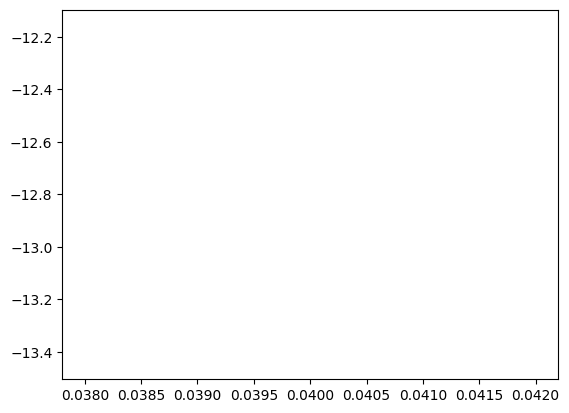

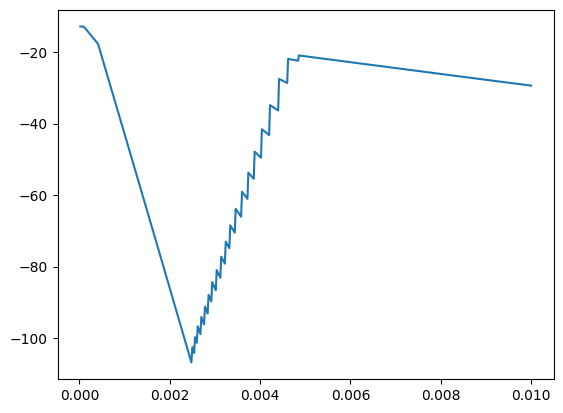

In [515]:
buy_oracle_dataset = [buy_profits[i][buy_max_index[1]][buy_max_index[2]] for i in range(len(oracle_mult_list))]
buy_lp_dataset = [buy_profits[buy_max_index[0]][i][buy_max_index[2]] for i in range(len(lp_multiplier_list))]
buy_price_dataset = [buy_profits[buy_max_index[0]][buy_max_index[1]][i] for i in range(len(price_move_list))]

# plt.plot(oracle_mult_list, oracle_dataset)
# plt.show()
plt.plot(lp_multiplier_list, buy_lp_dataset)
plt.show()
plt.plot(price_move_list, buy_price_dataset)
plt.show()

In [516]:

# Test monotonicity of lp multiplier
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with lp multiplier
for i in range(len(oracle_mult_list)):
    for j in range(len(price_move_list)):
        data = [buy_profits[i][k][j] for k in range(len(lp_multiplier_list))]
        for k in range(len(data) - 1):
            if data[k] * dir_sign >= data[k+1] * dir_sign:
                non_monotonic[(i,j)] = data
                break
if len(non_monotonic) == 0:
    print('lp multiplier profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

lp multiplier profits are monotonic


In [517]:
# Test monotonicity of price move
non_monotonic = {}
dir_sign = 1  # we expect profit to increase with price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        data = buy_profits[i][j]
        # print(data)
        for k in range(len(data) - 1):
            if data[k] * dir_sign >= data[k+1] * dir_sign:
                non_monotonic[(i,j)] = copy.deepcopy(data)
                break

if len(non_monotonic) == 0:
    print('price move profits are monotonic')
else:
    print('Non-monotonic data found')
    # pprint(non_monotonic)

print(price_move_list)


Non-monotonic data found
[2e-05, 4e-05, 6.000000000000001e-05, 8e-05, 0.0001, 0.00012000000000000002, 0.00014000000000000001, 0.00016, 0.00018, 0.0002, 0.00022, 0.00024000000000000003, 0.00026000000000000003, 0.00028000000000000003, 0.00030000000000000003, 0.00032, 0.00034, 0.00036, 0.00038, 0.0004, 0.00042, 0.00044, 0.00046, 0.00048000000000000007, 0.0005, 0.0005200000000000001, 0.00054, 0.0005600000000000001, 0.00058, 0.0006000000000000001, 0.00062, 0.00064, 0.0006600000000000001, 0.00068, 0.0007000000000000001, 0.00072, 0.0007400000000000001, 0.00076, 0.0007800000000000001, 0.0008, 0.0008200000000000001, 0.00084, 0.0008600000000000001, 0.00088, 0.0009000000000000001, 0.00092, 0.0009400000000000001, 0.0009600000000000001, 0.0009800000000000002, 0.001, 0.00102, 0.0010400000000000001, 0.0010600000000000002, 0.00108, 0.0011, 0.0011200000000000001, 0.0011400000000000002, 0.00116, 0.00118, 0.0012000000000000001, 0.0012200000000000002, 0.00124, 0.00126, 0.00128, 0.0013000000000000002, 0.00

In [518]:
# print(profits[-1][20][-1])

In [519]:
# print(buy_profits[-1][20][-1])

# profitability of remove liquidity attack where asset is sold to manipulate price

In [520]:
lp_price_move = 1
profits = []
# price_moves = []
for i in range(len(oracle_mult_list)):
    oracle_mult = oracle_mult_list[i]
    profits.append([])
    # price_moves.append([])
    for j in range(len(lp_multiplier_list)):
        lp_multiplier = lp_multiplier_list[j]
        profits[i].append([])
        # price_moves[i].append([])
        for k in range(len(price_move_list)):
            price_move = price_move_list[k]
            profits[i][j].append([])
            for l in range(len(lp_price_move_list)):

                lp_price_move = lp_price_move_list[l]

                trade_mult = 1/sqrt(1 - price_move) - 1

                trade_size = tokens['DOT']['liquidity'] * trade_mult

                init_oracle = {
                    'liquidity': {tkn: tokens[tkn]['liquidity'] for tkn in tokens},
                    'volume_in': {tkn: 0 for tkn in tokens},
                    'volume_out': {tkn: 0 for tkn in tokens},
                    'price': {tkn: oracle_mult * prices[tkn] for tkn in tokens},
                }

                omnipool: OmnipoolState = OmnipoolState(
                    tokens=tokens,
                    preferred_stablecoin='DAI',
                    oracles={'price': 19, 'volatility': 19},
                    last_oracle_values={
                        'price': copy.deepcopy(init_oracle),
                        'volatility': copy.deepcopy(init_oracle),
                    },
                    asset_fee = 0.0,
                    lrna_fee = 0.0,
                )

                market_prices = {tkn: usd_price(omnipool, tkn) for tkn in omnipool.asset_list}

                holdings = {tkn: 1000000000 for tkn in omnipool.asset_list}
                holdings[('omnipool', 'DOT')] = tokens['DOT']['liquidity'] * lp_multiplier
                share_prices = {('omnipool', 'DOT'): lrna_price(omnipool, 'DOT') * lp_price_move}
                agent = Agent(holdings=holdings, share_prices=share_prices)

                swap_state, swap_agent = execute_swap(
                    state=omnipool.copy(),
                    agent=agent.copy(),
                    tkn_sell='DOT',
                    tkn_buy='DAI',
                    sell_quantity=trade_size
                )

                # manipulated_price = swap_state.lrna['DOT'] / swap_state.liquidity['DOT']
                # init_spot_price = omnipool.lrna['DOT'] / omnipool.liquidity['DOT']
                # price_moves[i][j].append((init_spot_price - manipulated_price) / init_spot_price)

                remove_state, remove_agent = execute_remove_liquidity(
                    state=swap_state.copy(),
                    agent=swap_agent.copy(),
                    tkn_remove='DOT',
                    quantity=agent.holdings[('omnipool', 'DOT')]
                )

                global_state = GlobalState(
                    pools={'omnipool': remove_state},
                    agents={'attacker': remove_agent},
                    external_market=market_prices
                )

                arb_state = omnipool_arbitrage('omnipool', 20).execute(
                    state=global_state.copy(),
                    agent_id='attacker'
                )

                arbed_pool = arb_state.pools['omnipool']
                arbed_agent = arb_state.agents['attacker']

                initial_value = cash_out_omnipool(omnipool, agent, market_prices)
                final_value = cash_out_omnipool(arbed_pool, arbed_agent, market_prices)
                # profit_dict[(oracle_mult, lp_multiplier, trade_mult)] = final_value - initial_value
                profits[i][j][k].append(final_value - initial_value)

        # price_moves[i][j] = max(price_moves[i][j])


In [521]:
max_profit = profits[0][0][0][0]
max_index = (0, 0, 0, 0)
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            for l in range(len(lp_price_move_list)):
                if profits[i][j][k][l] > max_profit:
                    max_profit = profits[i][j][k][l]
                    max_index = (i, j, k, l)

print(max_profit)
print(profits[max_index[0]][max_index[1]][max_index[2]][max_index[3]])

-0.0078125
-0.0078125


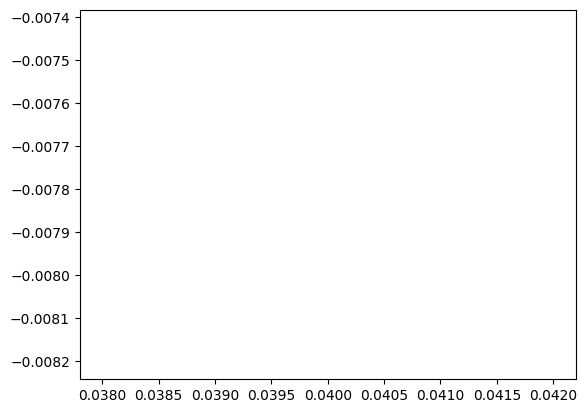

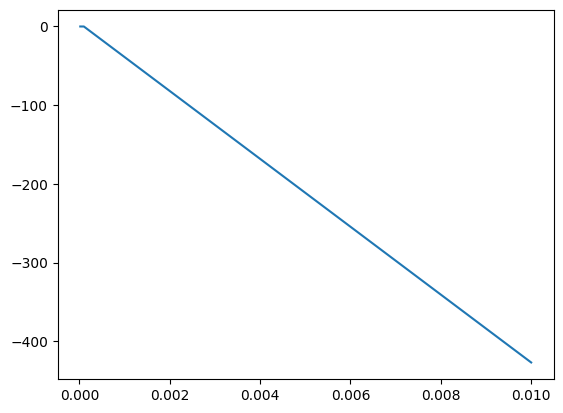

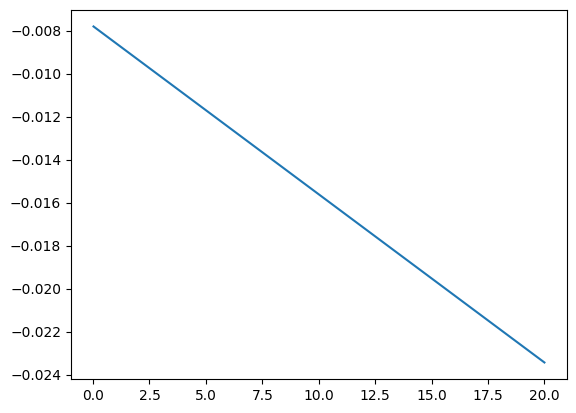

In [522]:
oracle_dataset = [profits[i][max_index[1]][max_index[2]][max_index[3]] for i in range(len(oracle_mult_list))]
lp_dataset = [profits[max_index[0]][i][max_index[2]][max_index[3]] for i in range(len(lp_multiplier_list))]
price_dataset = [profits[max_index[0]][max_index[1]][i][max_index[3]] for i in range(len(price_move_list))]
lp_price_dataset = [profits[max_index[0]][max_index[1]][max_index[2]][i] for i in range(len(lp_price_move_list))]

# plt.plot(oracle_mult_list, oracle_dataset)
# plt.show()
plt.plot(lp_multiplier_list, lp_dataset)
plt.show()
plt.plot(price_move_list, price_dataset)
plt.show()
plt.plot(lp_price_move_list, lp_price_dataset)
plt.show()

In [523]:

# Test monotonicity of lp multiplier
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with lp multiplier
for i in range(len(oracle_mult_list)):
    for j in range(len(price_move_list)):
        for k in range(len(lp_price_move_list)):
            data = [profits[i][l][j][k] for l in range(len(lp_multiplier_list))]
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break
if len(non_monotonic) == 0:
    print('lp multiplier profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

lp multiplier profits are monotonic


In [524]:

# Test monotonicity of price move
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(lp_price_move_list)):
            data = [profits[i][j][l][k] for l in range(len(price_move_list))]
            # print(data)
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break

if len(non_monotonic) == 0:
    print('price move profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

price move profits are monotonic


In [525]:

# Test monotonicity of price move
non_monotonic = {}
dir_sign = 1  # we expect profit to increase with lp price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            data = profits[i][j][k]
            # print(data)
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break

if len(non_monotonic) == 0:
    print('lp price move profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

Non-monotonic data found
{(0, 0, 0): [-0.0078125, -0.0234375],
 (0, 0, 1): [-0.015625, -0.0390625],
 (0, 0, 2): [-0.0234375, -0.05859375],
 (0, 0, 3): [-0.03125, -0.078125],
 (0, 0, 4): [-0.04296875, -0.09765625]}


In [526]:
lp_price_move = 1
profits = []
# price_moves = []
for i in range(len(oracle_mult_list)):
    oracle_mult = oracle_mult_list[i]
    profits.append([])
    # price_moves.append([])
    for j in range(len(lp_multiplier_list)):
        lp_multiplier = lp_multiplier_list[j]
        profits[i].append([])
        # price_moves[i].append([])
        for k in range(len(price_move_list)):
            price_move = price_move_list[k]
            profits[i][j].append([])
            for l in range(len(lp_price_move_list)):

                lp_price_move = lp_price_move_list[l]

                trade_mult = 1 - 1/sqrt(1 + price_move)

                trade_size = tokens['DOT']['liquidity'] * trade_mult

                init_oracle = {
                    'liquidity': {tkn: tokens[tkn]['liquidity'] for tkn in tokens},
                    'volume_in': {tkn: 0 for tkn in tokens},
                    'volume_out': {tkn: 0 for tkn in tokens},
                    'price': {tkn: oracle_mult * prices[tkn] for tkn in tokens},
                }

                omnipool: OmnipoolState = OmnipoolState(
                    tokens=tokens,
                    preferred_stablecoin='DAI',
                    oracles={'price': 19, 'volatility': 19},
                    last_oracle_values={
                        'price': copy.deepcopy(init_oracle),
                        'volatility': copy.deepcopy(init_oracle),
                    },
                    asset_fee = 0.0,
                    lrna_fee = 0.0,
                )

                market_prices = {tkn: usd_price(omnipool, tkn) for tkn in omnipool.asset_list}

                holdings = {tkn: 1000000000 for tkn in omnipool.asset_list}
                holdings[('omnipool', 'DOT')] = tokens['DOT']['liquidity'] * lp_multiplier
                share_prices = {('omnipool', 'DOT'): lrna_price(omnipool, 'DOT') * lp_price_move}
                agent = Agent(holdings=holdings, share_prices=share_prices)

                swap_state, swap_agent = execute_swap(
                    state=omnipool.copy(),
                    agent=agent.copy(),
                    tkn_buy='DOT',
                    tkn_sell='DAI',
                    buy_quantity=trade_size
                )

                # manipulated_price = swap_state.lrna['DOT'] / swap_state.liquidity['DOT']
                # init_spot_price = omnipool.lrna['DOT'] / omnipool.liquidity['DOT']
                # price_moves[i][j].append((init_spot_price - manipulated_price) / init_spot_price)

                remove_state, remove_agent = execute_remove_liquidity(
                    state=swap_state.copy(),
                    agent=swap_agent.copy(),
                    tkn_remove='DOT',
                    quantity=agent.holdings[('omnipool', 'DOT')]
                )

                global_state = GlobalState(
                    pools={'omnipool': remove_state},
                    agents={'attacker': remove_agent},
                    external_market=market_prices
                )

                arb_state = omnipool_arbitrage('omnipool', 20).execute(
                    state=global_state.copy(),
                    agent_id='attacker'
                )

                arbed_pool = arb_state.pools['omnipool']
                arbed_agent = arb_state.agents['attacker']

                initial_value = cash_out_omnipool(omnipool, agent, market_prices)
                final_value = cash_out_omnipool(arbed_pool, arbed_agent, market_prices)
                # profit_dict[(oracle_mult, lp_multiplier, trade_mult)] = final_value - initial_value
                profits[i][j][k].append(final_value - initial_value)

In [527]:
max_profit = profits[0][0][0][0]
max_index = (0, 0, 0, 0)
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            for l in range(len(lp_price_move_list)):
                if profits[i][j][k][l] > max_profit:
                    max_profit = profits[i][j][k][l]
                    max_index = (i, j, k, l)

print(max_profit)
print(profits[max_index[0]][max_index[1]][max_index[2]][max_index[3]])

0.08984375
0.08984375


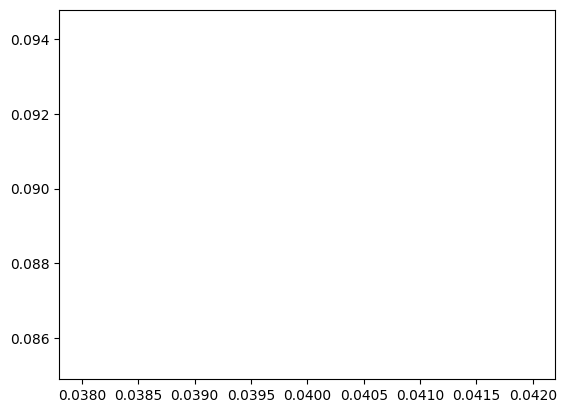

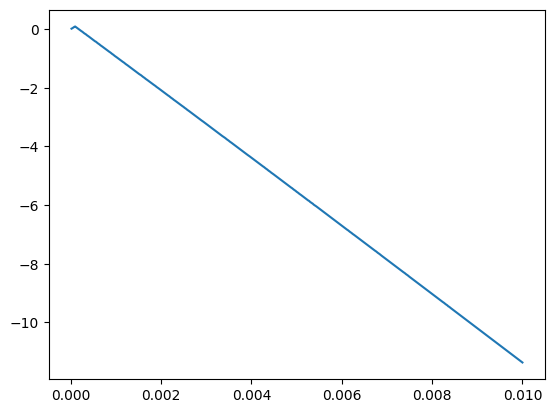

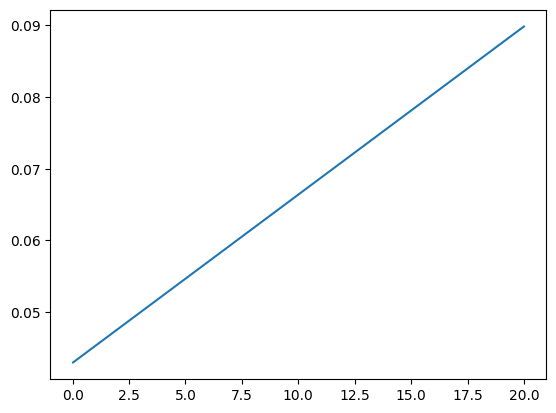

In [528]:
oracle_dataset = [profits[i][max_index[1]][max_index[2]][max_index[3]] for i in range(len(oracle_mult_list))]
lp_dataset = [profits[max_index[0]][i][max_index[2]][max_index[3]] for i in range(len(lp_multiplier_list))]
price_dataset = [profits[max_index[0]][max_index[1]][i][max_index[3]] for i in range(len(price_move_list))]
lp_price_dataset = [profits[max_index[0]][max_index[1]][max_index[2]][i] for i in range(len(lp_price_move_list))]

# plt.plot(oracle_mult_list, oracle_dataset)
# plt.show()
plt.plot(lp_multiplier_list, lp_dataset)
plt.show()
plt.plot(price_move_list, price_dataset)
plt.show()
plt.plot(lp_price_move_list, lp_price_dataset)
plt.show()

In [529]:

# Test monotonicity of lp multiplier
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with lp multiplier
for i in range(len(oracle_mult_list)):
    for j in range(len(price_move_list)):
        for k in range(len(lp_price_move_list)):
            data = [profits[i][l][j][k] for l in range(len(lp_multiplier_list))]
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break
if len(non_monotonic) == 0:
    print('lp multiplier profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

lp multiplier profits are monotonic


In [530]:
# Test monotonicity of price move
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(lp_price_move_list)):
            data = [profits[i][j][l][k] for l in range(len(price_move_list))]
            # print(data)
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break

if len(non_monotonic) == 0:
    print('price move profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

Non-monotonic data found
{(0, 0, 0): [0.01171875,
             0.01171875,
             0.0234375,
             0.03515625,
             0.04296875,
             -0.80859375,
             -1.65234375,
             -2.49609375,
             -3.34375,
             -4.19140625,
             -5.03515625,
             -5.8828125,
             -6.73046875,
             -7.57421875,
             -8.421875,
             -9.26953125,
             -10.1171875,
             -10.9609375,
             -11.80859375,
             -12.65234375,
             -13.5,
             -14.34765625,
             -15.1875,
             -16.04296875,
             -16.88671875,
             -17.734375,
             -18.578125,
             -19.42578125,
             -20.2734375,
             -21.11328125,
             -21.9609375,
             -22.80859375,
             -23.65625,
             -24.50390625,
             -25.34765625,
             -26.1953125,
             -27.04296875,
             -27.88671875,


In [531]:
# Test monotonicity of price move
non_monotonic = {}
dir_sign = 1  # we expect profit to increase with lp price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            data = profits[i][j][k]
            # print(data)
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break

if len(non_monotonic) == 0:
    print('lp price move profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

lp price move profits are monotonic
